In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import math
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow.keras.backend as K

In [3]:
plt.close()
df = pd.read_csv('facies_vectors.csv')
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [4]:
df.isna().sum()

Facies         0
Formation      0
Well Name      0
Depth          0
GR             0
ILD_log10      0
DeltaPHI       0
PHIND          0
PE           917
NM_M           0
RELPOS         0
dtype: int64

In [5]:
df = df.dropna()

In [6]:
df.isna().sum()

Facies       0
Formation    0
Well Name    0
Depth        0
GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
NM_M         0
RELPOS       0
dtype: int64

In [7]:
num_row, num_cols = df.shape
print(f"Number of datapoints : {num_row}")
print(f"Number of features : {num_cols}")

Number of datapoints : 3232
Number of features : 11


In [8]:
output_cols = [df.Facies.name]
print(f'Output feature are : {output_cols}')
input_cols = [cols for cols in df]
input_cols.remove(output_cols[0]) # input data = all data - output data.
input_cols = input_cols[3:] # start from Depth
del(input_cols[5])
print(f'Input layers are {input_cols}')

Output feature are : ['Facies']
Input layers are ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'RELPOS']


In [9]:
df[input_cols]

,GR,ILD_log10,DeltaPHI,PHIND,PE,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1.000
1,78.260,0.661,14.200,12.565,4.100,0.979
2,79.050,0.658,14.800,13.050,3.600,0.957
3,86.100,0.655,13.900,13.115,3.500,0.936
4,74.580,0.647,13.500,13.300,3.400,0.915
...,...,...,...,...,...,...
4144,46.719,0.947,1.828,7.254,3.617,0.685
4145,44.563,0.953,2.241,8.013,3.344,0.677
4146,49.719,0.964,2.925,8.013,3.190,0.669
4147,51.469,0.965,3.083,7.708,3.152,0.661


In [10]:
input_data = df[input_cols]
labels = df[output_cols]
print(input_data.head())
labels.head()

      GR  ILD_log10  DeltaPHI   PHIND   PE  RELPOS
0  77.45      0.664       9.9  11.915  4.6   1.000
1  78.26      0.661      14.2  12.565  4.1   0.979
2  79.05      0.658      14.8  13.050  3.6   0.957
3  86.10      0.655      13.9  13.115  3.5   0.936
4  74.58      0.647      13.5  13.300  3.4   0.915


,Facies
0,3
1,3
2,3
3,3
4,3


In [11]:
from sklearn.utils import shuffle
input_data, labels = shuffle(input_data, labels, random_state=42)

In [12]:
### visualize out data

# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
df.loc[:,'FaciesLabels'] = df.apply(lambda row: label_facies(row, facies_labels), axis=1)
df['Facies_cnn'] = df['Facies']
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies_cnn
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287,4.422030
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792,2.504243
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000,1.000000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000,2.000000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000,4.000000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250,6.000000
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000,9.000000


In [13]:
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels,Facies_cnn
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS,3
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS,3
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS,3
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS,3
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS,3


In [14]:
df.isna().sum()

Facies          0
Formation       0
Well Name       0
Depth           0
GR              0
ILD_log10       0
DeltaPHI        0
PHIND           0
PE              0
NM_M            0
RELPOS          0
FaciesLabels    0
Facies_cnn      0
dtype: int64

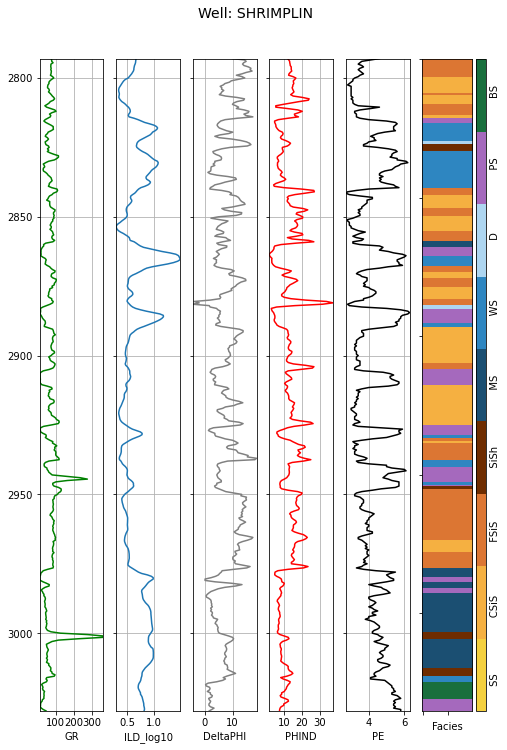

In [15]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    
make_facies_log_plot(
    df[df['Well Name'] == 'SHRIMPLIN'],
    facies_colors)


SS      259
CSiS    738
FSiS    615
SiSh    184
MS      217
WS      462
D        98
PS      498
BS      161
Name: Facies, dtype: int64

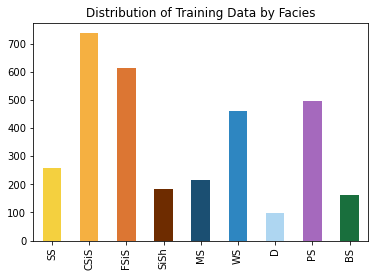

In [16]:
#In addition to individual wells, we can look at how the various facies are represented by the entire training set. 
#Let's plot a histgram of the number of training examples for each facies class
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = df['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

In [17]:
input_data.isna().sum()

GR           0
ILD_log10    0
DeltaPHI     0
PHIND        0
PE           0
RELPOS       0
dtype: int64

In [18]:
input_data = input_data.values
labels = labels.values

In [19]:
print(input_data.shape,labels.shape)

(3232, 6) (3232, 1)


In [20]:
labels = labels.squeeze()

In [21]:
print(input_data.shape,labels.shape)

(3232, 6) (3232,)


In [22]:
#Model_Seq
# normalize input data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(input_data)
input_data = scaler.transform(input_data)

In [23]:
print(input_data[0:10])
labels[0:10]

[[ 0.85913082  0.76623413  1.13622798  0.33344468  0.19529401 -0.71591662]
 [-0.97379961 -2.16999051 -0.16844266  0.53285259  3.00998359 -0.1300357 ]
 [-0.87755991  1.64710153 -0.6385908  -0.80974072  0.19082979 -0.82751299]
 [ 0.69057357 -1.09888885  1.97782757  1.31164764 -0.69754964 -0.77520219]
 [-1.47765613  2.08546746  0.10335575 -1.34301072  1.53455947  0.31634976]
 [-0.74929432  0.91924866 -0.20268046 -0.8409185   0.64171583  0.8185334 ]
 [-0.934059    1.01436579 -0.41308036 -1.04227502 -0.47433872 -1.27738583]
 [ 0.38133584 -1.21054809  0.61979187  0.11584974 -0.47433872 -0.85192469]
 [ 0.87485202  0.08800759 -0.68086205  1.78788829 -0.74553998  1.57180886]
 [-1.08015275  0.45193403 -0.42952981 -0.69802032 -0.41183967  1.11147386]]


array([4, 9, 6, 2, 8, 5, 6, 2, 3, 6], dtype=int64)

In [24]:
np.isnan(input_data).sum()

0

In [25]:
val_data = input_data[0:640]
input_data = input_data[641:]
val_labels = labels[0:640]
labels = labels[641:]

In [26]:
input_data.shape

(2591, 6)

In [27]:
from CLR import CyclicLR

In [109]:
## start model
from tensorflow.keras import regularizers
# Architecture
model_seq = models.Sequential()
model_seq.add(layers.Dense(512, activation='relu', input_shape = (input_data.shape[1],)))
model_seq.add(layers.Dropout(0.5))
model_seq.add(layers.Dense(256, activation='relu'))
model_seq.add(layers.Dropout(0.5))
model_seq.add(layers.Dense(128, activation='relu'))
model_seq.add(layers.Dropout(0.5))
model_seq.add(layers.Dense(128, activation='relu'))
model_seq.add(layers.Dropout(0.5))
model_seq.add(layers.Dense(64, activation='relu',kernel_regularizer = regularizers.l2()))
model_seq.add(layers.Dense(10, activation='softmax'))

model_seq.compile(
        optimizer = optimizers.Adamax(),
        loss = 'sparse_categorical_crossentropy',
        metrics=['acc']
    )

model_seq.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 512)               3584      
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)              

In [110]:
model = model_seq

In [99]:
from keras_lr_finder.lr_finder import LRFinder
lr_finder = LRFinder(model)
lr_finder.find(input_data, labels, start_lr=1e-6, end_lr=0.01,batch_size=128, epochs=80)

Epoch 1/80
21/21 [==============================] - 0s 6ms/step - loss: 3.1496 - acc: 0.0980
Epoch 2/80
21/21 [==============================] - 0s 6ms/step - loss: 3.1493 - acc: 0.0973
Epoch 3/80
21/21 [==============================] - 0s 6ms/step - loss: 3.1495 - acc: 0.1096
Epoch 4/80
21/21 [==============================] - 0s 6ms/step - loss: 3.1496 - acc: 0.1023
Epoch 5/80
21/21 [==============================] - 0s 5ms/step - loss: 3.1501 - acc: 0.1061
Epoch 6/80
21/21 [==============================] - 0s 5ms/step - loss: 3.1527 - acc: 0.1081
Epoch 7/80
21/21 [==============================] - 0s 5ms/step - loss: 3.1503 - acc: 0.0946
Epoch 8/80
21/21 [==============================] - 0s 6ms/step - loss: 3.1489 - acc: 0.1007
Epoch 9/80
21/21 [==============================] - 0s 6ms/step - loss: 3.1502 - acc: 0.0949
Epoch 10/80
21/21 [==============================] - 0s 6ms/step - loss: 3.1465 - acc: 0.1003
Epoch 11/80
21/21 [==============================] - 0s 6ms/step - lo

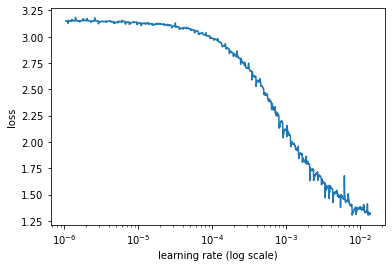

In [100]:
lr_finder.plot_loss(n_skip_beginning=10, n_skip_end=5)

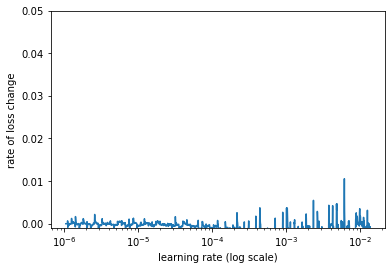

In [102]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.001, 0.05))

In [112]:
clr = CyclicLR(base_lr=1e-6, max_lr=1e-2, step_size=8,mode='exp_range', gamma=0.99990)

In [ ]:
K.set_value(model_seq.optimizer.lr, 0.01)

In [113]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, TerminateOnNaN
callbacks = [
    #ReduceLROnPlateau(monitor="val_loss",factor=0.2, patience=10, min_lr=5e-5, verbose=1),
    clr,
    ModelCheckpoint('model_seq.h5',monitor="val_loss", verbose=1, save_best_only=True, mode='auto'),
    TerminateOnNaN()
]

history = model_seq.fit(
    input_data,
    labels,
    epochs=1000,
    validation_data=(val_data, val_labels),
    verbose=2,
    batch_size=64,
    callbacks=callbacks
    )

Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.92405, saving model to model_seq.h5
41/41 - 0s - loss: 2.4594 - acc: 0.2945 - val_loss: 1.9240 - val_acc: 0.3891
Epoch 2/1000

Epoch 00002: val_loss improved from 1.92405 to 1.74612, saving model to model_seq.h5
41/41 - 0s - loss: 1.9126 - acc: 0.3805 - val_loss: 1.7461 - val_acc: 0.4641
Epoch 3/1000

Epoch 00003: val_loss improved from 1.74612 to 1.59518, saving model to model_seq.h5
41/41 - 0s - loss: 1.7396 - acc: 0.4195 - val_loss: 1.5952 - val_acc: 0.4437
Epoch 4/1000

Epoch 00004: val_loss improved from 1.59518 to 1.46886, saving model to model_seq.h5
41/41 - 0s - loss: 1.6386 - acc: 0.4377 - val_loss: 1.4689 - val_acc: 0.5328
Epoch 5/1000

Epoch 00005: val_loss improved from 1.46886 to 1.42366, saving model to model_seq.h5
41/41 - 0s - loss: 1.5532 - acc: 0.4682 - val_loss: 1.4237 - val_acc: 0.5281
Epoch 6/1000

Epoch 00006: val_loss improved from 1.42366 to 1.35200, saving model to model_seq.h5
41/41 - 0s - loss: 1.4888

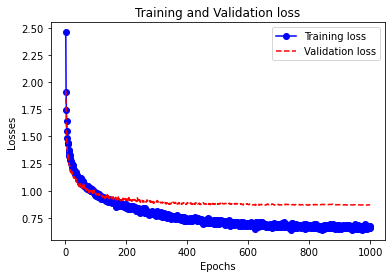

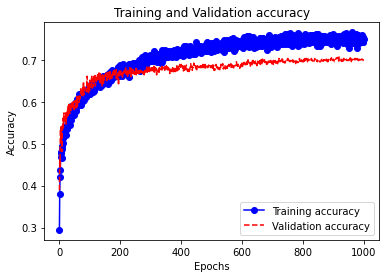

In [118]:
def model_plots(history):
    history_dict = history.history
    # plot histories

    epochs = history.epoch
    epochs = epochs[1:]
    epochs.append(len(epochs)+1)
    
    ## training loss and acc
    acc = history_dict['acc']
    loss = history_dict['loss']
    
    ## validation loss and acc
    val_acc = history_dict['val_acc']
    val_loss = history_dict['val_loss']
    
    plt.figure("Losses")
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation loss')
    plt.legend()
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.show()
    
    
    plt.figure("Accuracy")
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Validation accuracy')
    plt.legend()
    plt.title("Training and Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

model_plots(history)

In [116]:
clr.history.keys()

dict_keys(['lr', 'iterations', 'loss', 'acc'])

Text(0, 0.5, 'Learning Rate')

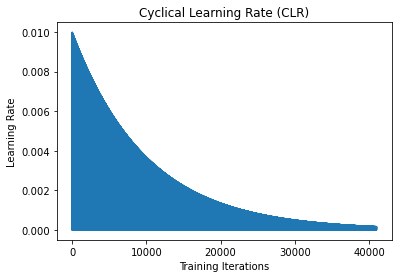

In [117]:
# plot Learning rates
iterations = clr.history['iterations']
plt.figure("Learning curve")
plt.plot(iterations, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")

In [ ]:
model_seq = models.load_model('model_seq.h5')

In [ ]:
input_data.shape

In [ ]:
cnn_data = input_data.reshape(input_data.shape[0], input_data.shape[1], 1)
cnnval_data = val_data.reshape(val_data.shape[0], val_data.shape[1], 1)
cnn_data.shape,cnnval_data.shape 

In [ ]:
## start model  
# Architecture
model_CNN = models.Sequential()
model_CNN.add(layers.Conv1D(64,3, activation='relu', input_shape = cnn_data.shape[1:],padding="same"))
model_CNN.add(layers.Conv1D(64,3, activation='relu', padding="same"))
model_CNN.add(layers.Dropout(0.5))
model_CNN.add(layers.Conv1D(64,3, activation='relu', padding="same"))
model_CNN.add(layers.Dropout(0.5))
model_CNN.add(layers.MaxPooling1D(2))
model_CNN.add(layers.Flatten())
# model.add(layers.Dense(16, activation='relu', input_shape = (input_data.shape[1],)))
# model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)))
# model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)))
# model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)))
# model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)))
# model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)))
# model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)))
# model.add(layers.Dropout(0.4))
# model.add(layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-4)))
#model.add(layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.l2()))
model_CNN.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2()))
model_CNN.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2()))
model_CNN.add(layers.Dense(10, activation='softmax'))

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
model_CNN.compile(
        optimizer = optimizers.Adam(lr=5e-5),
        loss = 'sparse_categorical_crossentropy',
        metrics=['acc']
    )

model_CNN.summary()
callbacks = [
    ReduceLROnPlateau(monitor="val_loss",factor=0.2, patience=10, min_lr=5e-6, verbose=1),
    ModelCheckpoint('model_CNN.h5',monitor="val_loss", verbose=1, save_best_only=True, mode='auto')
]

history = model_CNN.fit(
    cnn_data,
    labels,
    epochs=200,
    validation_data=(cnnval_data, val_labels),
    verbose=2,
    batch_size=128,
    callbacks=callbacks
    )

def model_plots(history):
    history_dict = history.history

    # plot histories

    epochs = history.epoch
    epochs = epochs[1:]
    epochs.append(len(epochs)+1)
    
    ## training loss and acc
    acc = history_dict['acc']
    loss = history_dict['loss']
    
    ## validation loss and acc
    val_acc = history_dict['val_acc']
    val_loss = history_dict['val_loss']
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.legend()
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.show()
    
    
    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.title("Training and Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

model_plots(history)


In [ ]:
#simple linear Model similar to SVM
import sys
input_data = df[input_cols]
input_stats = df[input_cols].describe()
means = input_stats.iloc[1]
stds = input_stats.iloc[2]

for col in input_cols:
    input_data[col] = (input_data[col]-means[col])/stds[col]
    
print(input_data[0:10])
labels = df[output_cols]
(input_data, labels) = shuffle_datas(input_data, labels)
input_data = input_data.values
labels = labels.values
labels = to_categorical(labels)
print(f'Shape {input_data.shape},{labels.shape}')
val_data = input_data[0:800]
input_data = input_data[800:]
val_labels = labels[0:800]
labels = labels[800:]


In [ ]:
model_svm = models.Sequential()
model_svm.add(layers.Dense(64,activation='relu',input_shape = (input_data.shape[1],)))
model_svm.add(layers.Dense(10,activation='softmax'))

model_svm.compile(
        optimizer = optimizers.Adam(2e-4),
        loss = 'categorical_crossentropy',
        metrics=['acc']
    )

model_svm.summary()

In [ ]:
history = model_svm.fit(
    input_data,
    labels,
    epochs=100,
    validation_data=(val_data, val_labels),
    verbose=2,
    batch_size=1024
    )

def model_plots(history):
    history_dict = history.history

    # plot histories

    epochs = history.epoch
    epochs = epochs[1:]
    epochs.append(len(epochs)+1)
    
    ## training loss and acc
    acc = history_dict['acc']
    loss = history_dict['loss']
    
    ## validation loss and acc
    val_acc = history_dict['val_acc']
    val_loss = history_dict['val_loss']
    
    plt.figure("Losses")
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.legend()
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.show()
    
    
    plt.figure("Accuracy")
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.title("Training and Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

model_plots(history)

In [ ]:
#RNN
input_data = df[input_cols]
input_stats = df[input_cols].describe()
means = input_stats.iloc[1]
stds = input_stats.iloc[2]

for col in input_cols:
    input_data[col] = (input_data[col]-means[col])/stds[col]
    
print(input_data[0:10])
labels = df[output_cols]
input_data = input_data.values
labels = labels.values
labels = to_categorical(labels)
print(f'Shape {input_data.shape},{labels.shape}')
val_data = input_data[0:500]
input_data = input_data[501:]
val_labels = labels[0:500]
labels = labels[501:]
input_data = np.expand_dims(input_data,axis=1)
val_data = np.expand_dims(val_data,axis=1)
print(f'Shape {input_data.shape},{labels.shape},{val_data.shape},{val_labels.shape}')

In [ ]:
input_data[0:10]

In [ ]:
def expand_dim(x):
    x = np.expand_dims(x,axis=0)

In [ ]:
## start model

# Architecture
model_RNN = models.Sequential()
model_RNN.add(layers.LSTM(512, activation='relu', input_shape = (input_data.shape[1], input_data.shape[2]), return_sequences=True))
model_RNN.add(layers.LSTM(256, return_sequences=True, activation='relu'))
model_RNN.add(layers.Dropout(0.5))
model_RNN.add(layers.LSTM(128, activation='relu', return_sequences=True))
model_RNN.add(layers.Dropout(0.5))
model_RNN.add(layers.LSTM(128, activation='relu', return_sequences=True))
model_RNN.add(layers.Dropout(0.5))
model_RNN.add(layers.LSTM(64, activation='relu', return_sequences=True))
model_RNN.add(layers.Dropout(0.5))
model_RNN.add(layers.LSTM(64, activation='relu', return_sequences=True))
model_RNN.add(layers.Dropout(0.5))
model_RNN.add(layers.LSTM(32, activation='relu', return_sequences=True))
model_RNN.add(layers.Dropout(0.5))
model_RNN.add(layers.LSTM(32, activation='relu', return_sequences=True))
model_RNN.add(layers.LSTM(10, activation='relu'))
model_RNN.add(layers.Dense(10,activation='softmax'))

In [ ]:
model_RNN.compile(
        optimizer = optimizers.Adam(lr = 2e-4),
        loss = 'categorical_crossentropy',
        metrics=['acc']
    )

model_RNN.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
callbacks = [
    EarlyStopping(monitor="val_loss",patience=30, verbose=1),
    ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=5, min_lr=0.00004, verbose=1),
    ModelCheckpoint('model_RNN.h5',monitor="val_loss", verbose=1, save_best_only=True, mode='auto')
]


history = model_RNN.fit(
    input_data,
    labels,
    epochs=500,
    validation_data=(val_data, val_labels),
    verbose=2,
    batch_size=256
    #callbacks=callbacks
    )

def model_plots(history):
    history_dict = history.history

    # plot histories

    epochs = history.epoch
    epochs = epochs[1:]
    epochs.append(len(epochs)+1)
    
    ## training loss and acc
    acc = history_dict['acc']
    loss = history_dict['loss']
    
    ## validation loss and acc
    val_acc = history_dict['val_acc']
    val_loss = history_dict['val_loss']
    
    plt.figure("Losses")
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.legend()
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.show()
    
    
    plt.figure("Accuracy")
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.title("Training and Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

model_plots(history)

In [ ]:
import pandas as pd
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data.head()

In [ ]:
feature_vectors = df.drop(['Formation', 'Well Name','Facies','Depth','FaciesLabels'], axis=1)
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name'], axis=1)
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(feature_vectors)
X_unknown = scaler.transform(well_features)

In [ ]:
print(X_unknown.shape)
X_unknown = X_unknown[:,1:]
print(X_unknown.shape)

In [ ]:
well_data.head()

In [ ]:
#predict facies of unclassified data
y_unknown_seq = model_seq.predict_classes(X_unknown)
well_data['Facies_seq'] = y_unknown_seq

In [ ]:
y_unknown_seq

In [ ]:
X_unknown = X_unknown.reshape(830,7,1)
y_unknown_CNN = model_CNN.predict_classes(X_unknown)
well_data['Facies_CNN'] = y_unknown_CNN

In [ ]:
y_unknown_CNN

In [ ]:
X_unknown = X_unknown.reshape(-1,1,7)
y_unknown_RNN = model_RNN.predict_classes(X_unknown)
y_unknown_RNN.squeeze()

In [ ]:
well_data['Facies_RNN'] = y_unknown_RNN

In [ ]:
well_data['Well Name'].unique()

In [ ]:
well_data

In [ ]:
def predict_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()

    cluster_seq=np.repeat(np.expand_dims(logs['Facies_seq'].values,1), 100, 1)
    cluster_CNN=np.repeat(np.expand_dims(logs['Facies_CNN'].values,1), 100, 1)
    cluster_RNN=np.repeat(np.expand_dims(logs['Facies_RNN'].values,1), 100, 1) #1
   
    
     
    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(10, 14))   #2: ncols=6 to 7
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    
    
    im_seq=ax[5].imshow(cluster_seq, interpolation='none', aspect='auto',  #3
                    cmap=cmap_facies,vmin=1,vmax=9)
    divider_seq = make_axes_locatable(ax[5])
    cax_seq = divider_seq.append_axes("right", size="20%", pad=0.05)
    cbar_seq=plt.colorbar(im_seq, cax=cax_seq)
    cbar_seq.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar_seq.set_ticks(range(0,1)); cbar_seq.set_ticklabels('')
    
    
    im_CNN=ax[6].imshow(cluster_CNN, interpolation='none', aspect='auto',  #3
                    cmap=cmap_facies,vmin=1,vmax=9)
    divider_CNN = make_axes_locatable(ax[6])
    cax_CNN = divider_CNN.append_axes("right", size="20%", pad=0.05)
    cbar_CNN=plt.colorbar(im_CNN, cax=cax_CNN)
    cbar_CNN.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar_CNN.set_ticks(range(0,1)); cbar_CNN.set_ticklabels('')
    
    
    
    im_RNN=ax[7].imshow(cluster_RNN, interpolation='none', aspect='auto',  #3
                    cmap=cmap_facies,vmin=1,vmax=9)
    divider_RNN = make_axes_locatable(ax[7])
    cax_RNN = divider_RNN.append_axes("right", size="20%", pad=0.05)
    cbar_RNN=plt.colorbar(im_RNN, cax=cax_RNN)
    cbar_RNN.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar_RNN.set_ticks(range(0,1)); cbar_RNN.set_ticklabels('')
    
    
    
    
    num_facies_plot = 3
    for i in range(len(ax)-num_facies_plot): #3 two is the problem
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies_seq')
    ax[6].set_xlabel('Facies_CNN')
    ax[7].set_xlabel('Facies_RNN') #4
     
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([]) ; ax[7].set_yticklabels([]) #5
    ax[5].set_xticklabels([]); ax[6].set_xticklabels([]); ax[7].set_xticklabels([])  #6
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    
    facies = {'SS':1,'CSiS':2,'FSiS':3,'SiSh':4,'MS':5,'WS':6,'D':7,'PS':8,'BS':9} #7 for legends
    hands = []
    for k, col in zip(facies.keys(), facies_colors):
        hands.append(mpatches.Patch(color=col, label=k))
    plt.legend(handles=hands, loc=(2, 0.5), fontsize=18)


In [ ]:
predict_facies_log_plot(well_data[df['Well Name'] == 'SHRIMPLIN'], facies_colors)

labels = to_categorical(labels)

In [ ]:
from sklearn.metrics import f1_score_score 
f1=f1_score(y_unknown_CNN)

In [ ]:
model_1 = models.Sequential()
model_1.add(layers.Dense(100,input_shape=(2,1)))
for unit in [10,10,10]:
    model_1.add(layers.Dense(unit,activation='relu'))
model_1.compile(optimizer='rmsprop',
                loss = 'mse'
               )
            

In [ ]:
model_1.summary()